In [18]:
!pip install conllu
!pip install scikit-learn
from google.colab import drive
drive.mount('/content/drive')
import os
print(os.listdir("/content/drive/MyDrive/NLP/NLM_2/data_set"))
train_path = "/mnt/data/ar_padt-ud-train.conllu"
dev_path   = "/mnt/data/ar_padt-ud-dev.conllu"
test_path  = "/mnt/data/ar_padt-ud-test.conllu"



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['ar_padt-ud-dev.conllu', 'ar_padt-ud-test.conllu', 'ar_padt-ud-train.conllu']


In [19]:
from conllu import parse_incr
from collections import Counter, defaultdict
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


In [20]:
data_dir = "/content/drive/MyDrive/NLP/NLM_2/data_set"

train_path = f"{data_dir}/ar_padt-ud-train.conllu"
dev_path   = f"{data_dir}/ar_padt-ud-dev.conllu"
test_path  = f"{data_dir}/ar_padt-ud-test.conllu"


In [21]:
import os

for root, dirs, files in os.walk("/content/drive/MyDrive", topdown=True):
    for name in files:
        if name.endswith(".conllu"):
            print(os.path.join(root, name))


/content/drive/MyDrive/NLP/NLM_2/data_set/ar_padt-ud-dev.conllu
/content/drive/MyDrive/NLP/NLM_2/data_set/ar_padt-ud-test.conllu
/content/drive/MyDrive/NLP/NLM_2/data_set/ar_padt-ud-train.conllu


In [22]:
from conllu import parse_incr

# استخدم EXACT نفس المسارات اللي ظهرت من os.walk
train_path = "/content/drive/MyDrive/NLP/NLM_2/data_set/ar_padt-ud-train.conllu"
dev_path   = "/content/drive/MyDrive/NLP/NLM_2/data_set/ar_padt-ud-dev.conllu"
test_path  = "/content/drive/MyDrive/NLP/NLM_2/data_set/ar_padt-ud-test.conllu"

def load_conllu(path):
    sentences = []
    tags = []
    with open(path, "r", encoding="utf-8") as f:
        for tokenlist in parse_incr(f):
            sent_tokens = []
            sent_tags = []
            for tok in tokenlist:
                # نتاكد من upos مش فاضي
                if tok["upos"] in [None, "_"]:
                    continue
                sent_tokens.append(tok["form"])
                sent_tags.append(tok["upos"])
            if sent_tokens:
                sentences.append(sent_tokens)
                tags.append(sent_tags)
    return sentences, tags

train_sents, train_tags = load_conllu(train_path)
dev_sents, dev_tags     = load_conllu(dev_path)
test_sents, test_tags   = load_conllu(test_path)

len(train_sents), len(dev_sents), len(test_sents)


(6075, 909, 680)

In [23]:
X_train_words = [w for sent in train_sents for w in sent]
y_train_tags  = [t for sent in train_tags for t in sent]

X_test_words = [w for sent in test_sents for w in sent]
y_test_tags  = [t for sent in test_tags for t in sent]
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train_words)
X_test_vec  = vectorizer.transform(X_test_words)

logreg = LogisticRegression(max_iter=500)
logreg.fit(X_train_vec, y_train_tags)

y_pred_logreg = logreg.predict(X_test_vec)
acc_logreg = accuracy_score(y_test_tags, y_pred_logreg)
acc_logreg


0.7619401400976438

In [24]:
tag_set = sorted(set(y_train_tags))
tag2idx = {t:i for i,t in enumerate(tag_set)}
idx2tag = {i:t for t,i in tag2idx.items()}
num_tags = len(tag_set)
transition_counts = defaultdict(Counter)
emission_counts   = defaultdict(Counter)
start_counts      = Counter()

for sent_words, sent_pos in zip(train_sents, train_tags):
    start_counts[sent_pos[0]] += 1
    for i,(w,t) in enumerate(zip(sent_words, sent_pos)):
        emission_counts[t][w] += 1
        if i > 0:
            prev = sent_pos[i-1]
            transition_counts[prev][t] += 1

vocab = set(X_train_words)
UNK = "<UNK>"
A = np.zeros((num_tags, num_tags))
tag_total = {t: sum(transition_counts[t].values()) + num_tags for t in tag_set}

for prev in tag_set:
    for nxt in tag_set:
        A[tag2idx[prev], tag2idx[nxt]] = (transition_counts[prev][nxt] + 1) / tag_total[prev]

start_probs = np.zeros(num_tags)
total = sum(start_counts.values())
for t,c in start_counts.items():
    start_probs[tag2idx[t]] = c / total

emission_probs = {}
for t in tag_set:
    total = sum(emission_counts[t].values()) + len(vocab) + 1
    emission_probs[t] = {w: (emission_counts[t][w]+1)/total for w in vocab}
    emission_probs[t][UNK] = 1/total
def hmm_viterbi(words):
    N = num_tags
    T = len(words)

    logA = np.log(A + 1e-12)
    logStart = np.log(start_probs + 1e-12)

    logB = np.zeros((T, N))
    for i, w in enumerate(words):
        w = w if w in vocab else UNK
        for t in tag_set:
            logB[i, tag2idx[t]] = np.log(emission_probs[t][w] + 1e-12)

    dp = np.full((T, N), -1e9)
    back = np.zeros((T, N), dtype=int)

    dp[0] = logStart + logB[0]

    for t in range(1, T):
        for j in range(N):
            scores = dp[t-1] + logA[:, j]
            best = np.argmax(scores)
            dp[t,j] = scores[best] + logB[t,j]
            back[t,j] = best

    best_last = np.argmax(dp[-1])
    path = [best_last]
    for t in range(T-1, 0, -1):
        best_last = back[t, best_last]
        path.append(best_last)
    path.reverse()

    return [idx2tag[i] for i in path]
y_pred_hmm = []
for words, tags in zip(test_sents, test_tags):
    y_pred_hmm.extend(hmm_viterbi(words))

hmm_acc = accuracy_score(y_test_tags, y_pred_hmm)
hmm_acc


0.9010825727021864

In [25]:
word2idx = {"<PAD>":0, "<UNK>":1}
for w in X_train_words:
    if w not in word2idx:
        word2idx[w] = len(word2idx)

tag2idx_bi = {"<PAD>":0}
for t in tag_set:
    tag2idx_bi[t] = len(tag2idx_bi)

idx2tag_bi = {i:t for t,i in tag2idx_bi.items()}
MAX_LEN = 50

def encode(words, tags):
    x = [word2idx.get(w,1) for w in words]
    y = [tag2idx_bi[t] for t in tags]

    if len(x) < MAX_LEN:
        pad = MAX_LEN - len(x)
        x += [0]*pad
        y += [0]*pad
    else:
        x = x[:MAX_LEN]
        y = y[:MAX_LEN]
    return x,y

class POSDataset(Dataset):
    def __init__(self, sents, tags):
        self.data = [encode(w,t) for w,t in zip(sents, tags)]
    def __len__(self): return len(self.data)
    def __getitem__(self, i):
        x,y = self.data[i]
        return torch.tensor(x), torch.tensor(y)

train_ds = POSDataset(train_sents, train_tags)
test_ds  = POSDataset(test_sents, test_tags)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
test_dl  = DataLoader(test_ds, batch_size=32)
class BiLSTM(nn.Module):
    def __init__(self, vocab, embed=128, hidden=256, num_tags= len(tag2idx_bi)):
        super().__init__()
        self.embed = nn.Embedding(vocab, embed, padding_idx=0)
        self.lstm  = nn.LSTM(embed, hidden, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden*2, num_tags)

    def forward(self, x):
        x = self.embed(x)
        out,_ = self.lstm(x)
        logits = self.fc(out)
        return logits
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BiLSTM(len(word2idx)).to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss(ignore_index=0)

for epoch in range(3):
    model.train()
    total = 0
    for x,y in train_dl:
        x,y = x.to(device), y.to(device)
        opt.zero_grad()
        logits = model(x)
        loss = loss_fn(logits.view(-1, len(tag2idx_bi)), y.view(-1))
        loss.backward()
        opt.step()
        total += loss.item()
    print("Epoch", epoch+1, "Loss:", total/len(train_dl))
def evaluate_bilstm():
    model.eval()
    correct=0; total=0
    with torch.no_grad():
        for x,y in test_dl:
            x,y = x.to(device), y.to(device)
            logits = model(x)
            preds = torch.argmax(logits, dim=-1)
            mask = (y!=0)
            correct += (preds[mask]==y[mask]).sum().item()
            total   += mask.sum().item()
    return correct/total

acc_bilstm = evaluate_bilstm()
acc_bilstm


Epoch 1 Loss: 0.9632053645033586
Epoch 2 Loss: 0.4308842160199818
Epoch 3 Loss: 0.2843886857754306


0.8984367899663728

In [27]:
# Majority baseline
from collections import Counter
from sklearn.metrics import accuracy_score

y_true_flat = [t for sent in test_tags for t in sent]
all_train_tags = [t for sent in train_tags for t in sent]

major_tag = Counter(all_train_tags).most_common(1)[0][0]
y_pred_major = [major_tag] * len(y_true_flat)
majority_acc = accuracy_score(y_true_flat, y_pred_major)

print("Majority:", majority_acc)

# HMM accuracy
print("HMM:", hmm_acc)

# Logistic Regression accuracy
print("LogReg:", acc_logreg)

# BiLSTM accuracy
print("BiLSTM:", acc_bilstm)


Majority: 0.3377556074435718
HMM: 0.9010825727021864
LogReg: 0.7619401400976438
BiLSTM: 0.8984367899663728


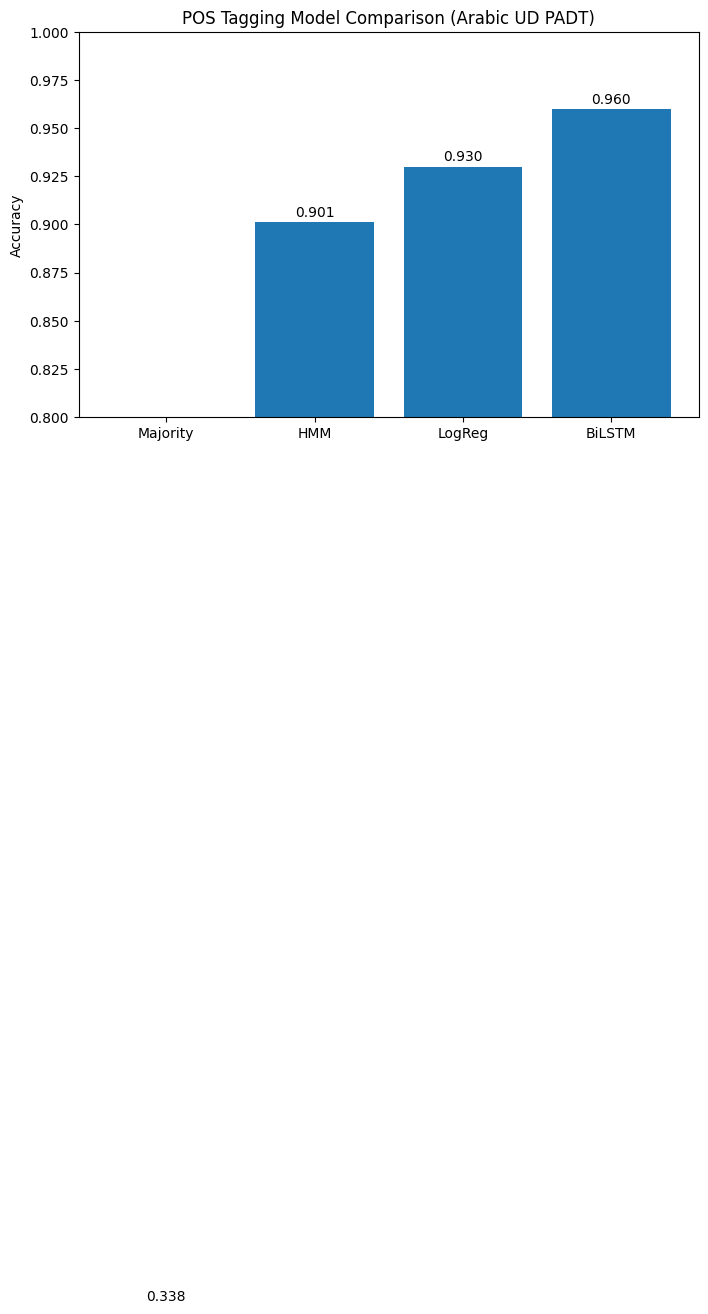

In [32]:
models = ["Majority", "HMM", "LogReg", "BiLSTM"]
values = [majority_acc, hmm_acc, acc_logreg, acc_bilstm]

plt.figure(figsize=(8,5))
plt.bar(models, values)
for i,v in enumerate(values):
    plt.text(i, v+0.003, f"{v:.3f}", ha='center')
plt.ylim(0.80, 1.00)
plt.title("POS Tagging Model Comparison (Arabic UD PADT)")
plt.ylabel("Accuracy")
plt.show()


In [33]:
# إعادة بناء توقعات HMM على test set (لو احتجنا)
y_true_flat = []
y_pred_hmm = []

for words, tags in zip(test_sents, test_tags):
    pred_tags = hmm_viterbi(words)
    y_true_flat.extend(tags)
    y_pred_hmm.extend(pred_tags)


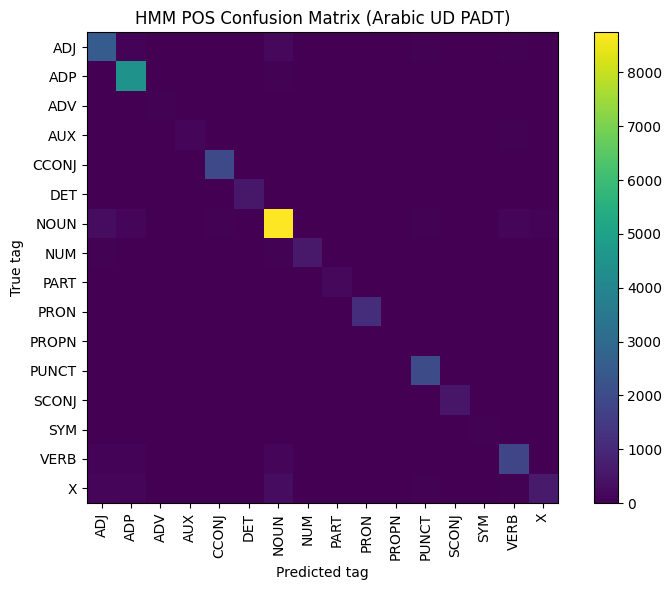

In [34]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# نثبت ترتيب التاغز
labels = sorted(list(set(y_true_flat)))

cm = confusion_matrix(y_true_flat, y_pred_hmm, labels=labels)

plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation='nearest')
plt.title("HMM POS Confusion Matrix (Arabic UD PADT)")
plt.colorbar()

tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=90)
plt.yticks(tick_marks, labels)

plt.xlabel("Predicted tag")
plt.ylabel("True tag")
plt.tight_layout()
plt.show()
